<h1>Fashion-Mnist dataset</h1>

<b>Designing an estimator. Sometimes it is preferable for performance [Estimators are higher level API]</b>

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
# How many categories we are predicting from (0-9)
LABEL_DIMENSIONS = 10
(train_images, train_labels), (test_images, test_labels) =tf.keras.datasets.fashion_mnist.load_data()
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images)

4423680/4422102 [==============================] - 1s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
test_images.shape

(10000, 28, 28)

<b>image shapes</b>

In [7]:
train_images=train_images.reshape(TRAINING_SIZE,28,28,1)
test_images=test_images.reshape(TEST_SIZE,28,28,1)

In [9]:
train_images.shape

(60000, 28, 28, 1)

<b>normalize the images</b>

In [11]:
train_images=np.asarray(train_images, dtype=np.float32)/255;

In [12]:
test_images=np.asarray(test_images, dtype=np.float32)/255;

<b>converting class vector into binary class matrix</b>

In [14]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [16]:
train_labels = tf.keras.utils.to_categorical(train_labels, LABEL_DIMENSIONS)

In [17]:
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
test_labels = tf.keras.utils.to_categorical(test_labels, LABEL_DIMENSIONS)

<b>making labels to float</b>

In [19]:
train_labels = np.asarray(train_labels, dtype=np.float32)


In [20]:
test_labels = np.asarray(test_labels, dtype=np.float32)

In [21]:
train_labels.shape

(60000, 10)

<b>defining an estimator</b>

In [23]:
inputs=tf.keras.Input(shape=(28,28,1))
x=tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=2,activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)
x=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=2,activation='relu')(x)
x=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2)(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
predictions=tf.keras.layers.Dense(LABEL_DIMENSIONS,activation='softmax')(x)
model=tf.keras.Model(inputs=inputs,outputs=predictions)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)               

<b>compiling the estimator</b>

In [25]:
optimizer = tf.keras.optimizers.SGD()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

<b>want to run on CPU</b>

In [27]:
strategy = None
config=tf.estimator.RunConfig(train_distribute=strategy)

<b>converting tf.keras model into an estimator</b>

In [28]:
estimator=tf.keras.estimator.model_to_estimator(model,config=config)

INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptzbq6pbq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, 

<b>defining training function for training and testing</b>

In [37]:
def in_function(images,epochs,labels,batch_size):
#     converting the input into dataset
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))
#     https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
    SHUFFLE_SIZE=5000
    dataset = dataset.shuffle(SHUFFLE_SIZE).repeat(epochs).batch(batch_size)
#     Creates a Dataset that prefetches elements from this dataset.
    dataset=dataset.prefetch(None)
    return dataset

<b>let's see the effect of in_function()</b>

In [38]:
BATCH_SIZE=512
EPOCHS=50
input_fn=in_function(train_images,EPOCHS, train_labels, BATCH_SIZE)

In [40]:
input_fn

<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [42]:
estimator_train_results = estimator.train(input_fn=lambda:in_function(train_images,EPOCHS, train_labels, BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmptzbq6pbq/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: /tmp/tmptzbq6pbq/keras/keras_model.ckpt
INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.
INFO:tensorflow:Warm-started 8 variables.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptzbq6pbq/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.2895842, step = 0
INFO:tensorflow:global_step/sec: 31.5797
INFO:tensorflow:loss = 2.2572503, step = 100 (3

In [48]:
estimator_train_results

<b>prediction</b>

In [46]:
returned_vals=estimator.evaluate(lambda:in_function(test_images,1,test_labels,BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-06-13T22:59:14Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptzbq6pbq/model.ckpt-5860
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.87349s
INFO:tensorflow:Finished evaluation at 2022-06-13-22:59:15
INFO:tensorflow:Saving dict for global step 5860: accuracy = 0.7743, global_step = 5860, loss = 0.61987025
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5860: /tmp/tmptzbq6pbq/model.ckpt-5860


In [47]:
returned_vals

{'accuracy': 0.7743, 'loss': 0.61987025, 'global_step': 5860}

<b>Running on GPU</b>

In [49]:
strategy = tf.distribute.MirroredStrategy()
config=tf.estimator.RunConfig(train_distribute=strategy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


In [51]:
estimator_train_results = estimator.train(input_fn=lambda:in_function(train_images,EPOCHS, train_labels, BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptzbq6pbq/model.ckpt-5860
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5860...
INFO:tensorflow:Saving checkpoints for 5860 into /tmp/tmptzbq6pbq/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5860...
INFO:tensorflow:loss = 0.6551707, step = 5860
INFO:tensorflow:global_step/sec: 32.5986
INFO:tensorflow:loss = 0.66419804, step = 5960 (3.069 sec)
INFO:tensorflow:global_step/sec: 33.8495
INFO:tensorflow:loss = 0.59160995, step = 6060 (2.954 sec)
INFO:tensorflow:global_step/sec: 31.3935
INFO:tensorflow:loss = 0.53852093, step = 6160 (3.185 sec)
INFO:tensorflow:global_step/sec: 36.258

In [52]:
returned_vals=estimator.evaluate(lambda:in_function(test_images,1,test_labels,BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-06-14T00:21:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptzbq6pbq/model.ckpt-11720
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.03490s
INFO:tensorflow:Finished evaluation at 2022-06-14-00:21:41
INFO:tensorflow:Saving dict for global step 11720: accuracy = 0.816, global_step = 11720, loss = 0.5260291
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11720: /tmp/tmptzbq6pbq/model.ckpt-11720


In [53]:
returned_vals

{'accuracy': 0.816, 'loss': 0.5260291, 'global_step': 11720}

<h1>Transfer learning with Inception-V3</h1>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers,models
import tensorflow_datasets as tfdts

<b>Getting the data</b>

In [2]:
(training_set, validation_set,testing_set), dataset_info = tfdts.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

<b>resize the data</b>

In [3]:
SIZE=299
def format_example(image,label):
    print(label)
    image=tf.cast(image,tf.float32)
    image=image/127.5-1
    image = tf.image.resize(image,(SIZE,SIZE))
#     label=tf.keras.utils.to_categorical(label, 5)
    return image,label
training_set=training_set.map(format_example)
validation_set=validation_set.map(format_example)
testing_set=testing_set.map(format_example)

Tensor("args_1:0", shape=(), dtype=int64)
Tensor("args_1:0", shape=(), dtype=int64)
Tensor("args_1:0", shape=(), dtype=int64)


<b>model declaration</b>

In [4]:
base_model=InceptionV3(weights='imagenet',include_top=True)

In [58]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [4]:
base_model = InceptionV3(input_shape=(SIZE,SIZE,3),weights='imagenet', include_top=False)

In [5]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

<b>Note: When include_top=false then global_avg_pooling layer and prediction layers are removed</b>

<b>Creating training, validation and testing batch</b>

In [5]:
shuffle_buffer_size=2000
batch_size=32
train_batch =  training_set.shuffle(shuffle_buffer_size).batch(batch_size)
validation_batch = validation_set.batch(batch_size)
testing_batch= testing_set.batch(batch_size)

<b>Let's take a batch and inspect</b></br>
<p>I tried this first to see the shapes of the layers</p>

In [6]:
for image_batch, label_batch in train_batch.take(1):
    pass
print (image_batch.shape)

(32, 299, 299, 3)


In [7]:
features=base_model(image_batch)

In [8]:
features.shape

TensorShape([32, 8, 8, 2048])

In [9]:
Global_Average=tf.keras.layers.GlobalAveragePooling2D()(features)
Global_Average.shape

TensorShape([32, 2048])

In [10]:
Dense_1=tf.keras.layers.Dense(5,activation='softmax')(Global_Average)
Dense_1.shape

TensorShape([32, 5])

In [18]:
Dense_1

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[0.1829337 , 0.13686515, 0.23016529, 0.22319332, 0.2268425 ],
       [0.18428273, 0.14977156, 0.08804423, 0.08392362, 0.49397781],
       [0.10866433, 0.08538228, 0.05679857, 0.05776054, 0.69139427],
       [0.13764997, 0.09716082, 0.07751247, 0.25201395, 0.43566284],
       [0.2105196 , 0.13692254, 0.25731802, 0.1923139 , 0.20292595],
       [0.26921192, 0.09774149, 0.20877749, 0.11175133, 0.31251782],
       [0.15532608, 0.09442151, 0.0457446 , 0.38457334, 0.31993446],
       [0.24934345, 0.21109077, 0.13837008, 0.1084218 , 0.2927739 ],
       [0.10876686, 0.12068775, 0.06642132, 0.14324568, 0.5608784 ],
       [0.1155415 , 0.14213312, 0.08124637, 0.04956693, 0.6115121 ],
       [0.08468071, 0.10782321, 0.12457558, 0.15151064, 0.53140986],
       [0.38911816, 0.10591631, 0.06370818, 0.11516909, 0.32608828],
       [0.17425196, 0.2325025 , 0.07720692, 0.12642984, 0.38960874],
       [0.06353517, 0.13707192, 0.12287574, 0.09792478

<b>Now let's create the model that we will actually work with not dummy</b>

In [11]:
Global_avg=tf.keras.layers.GlobalAveragePooling2D()
dense_1=tf.keras.layers.Dense(5,activation='softmax')

In [12]:
model = tf.keras.Sequential([
    base_model,
    Global_avg,
    dense_1
])

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [24]:
history = model.fit(train_batch,epochs=10,validation_data=validation_batch)

Epoch 1/10
92/92 [==============================] - 327s 4s/step - loss: 0.7011 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.4382 - val_sparse_categorical_accuracy: 0.8638
Epoch 2/10
92/92 [==============================] - 324s 4s/step - loss: 0.3729 - sparse_categorical_accuracy: 0.8835 - val_loss: 0.3769 - val_sparse_categorical_accuracy: 0.8774
Epoch 3/10
92/92 [==============================] - 359s 4s/step - loss: 0.2954 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.3422 - val_sparse_categorical_accuracy: 0.8856
Epoch 4/10
92/92 [==============================] - 327s 4s/step - loss: 0.2526 - sparse_categorical_accuracy: 0.9230 - val_loss: 0.3198 - val_sparse_categorical_accuracy: 0.9019
Epoch 5/10
92/92 [==============================] - 327s 4s/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9319 - val_loss: 0.3045 - val_sparse_categorical_accuracy: 0.9046
Epoch 6/10
92/92 [==============================] - 326s 4s/step - loss: 0.1982 - sparse_categorical_accu

In [25]:
model.evaluate(testing_batch)

12/12 [==============================] - 33s 3s/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9155


[0.22176286578178406, 0.9155313372612]

<b>instead freezing all the layers, we want to train 1st two inception block. that's why let's freeze first 172 layers and unfreeze the rest</b>

<b>we can fine-tune it according to our needs</b>

In [74]:
for layer in model.layers[:172]:
    layers.trainable=True
for layer in model.layers[172:]:
    layers.trainable=False

<b>let's recompile the model</b>

In [75]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),loss='categorical_crossentropy')

<b>let's try with real data. Find data and </b>

In [77]:
model.fit(X_train,Y_train)

ValueError: in user code:

    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/keras/layers/convolutional.py:247 call
        outputs = self._convolution_op(inputs, self.kernel)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1011 convolution_v2
        return convolution_internal(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:1141 convolution_internal
        return op(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py:2585 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py:975 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3477 _create_op_internal
        ret = Operation(
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/mahmud/anaconda3/envs/computer-vision/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 3 from 1 for '{{node functional_5/conv2d_313/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true](functional_5/activation_310/Relu, functional_5/conv2d_313/Conv2D/ReadVariableOp)' with input shapes: [?,1,1,96], [3,3,96,96].


<h1>Transfer learning with MobileNetV2 to classify Flower Species</h1>

In [1]:
import tensorflow as tf
import os
import numpy as np
import time
import tensorflow_datasets as tfdts
import matplotlib.pyplot as plt

<b>Split the datasets</b>

In [2]:
# split_ratio=(8,1,1)

In [3]:
# (train_set) ,dataset_info = tfdts.load("tf_flowers", 
#                                            split=["train"],
#                                            as_supervised=False, with_info=True)

In [5]:
(training_set, validation_set), dataset_info = tfdts.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

<b>let's get label names and show some image</b>

In [6]:
get_label_name = dataset_info.features['label']

In [7]:
print(get_label_name)

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)


In [8]:
# converting to human readable format
get_label_name=get_label_name.int2str

In [9]:
print(get_label_name)

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>


In [10]:
num_classes = dataset_info.features['label'].num_classes

In [11]:
num_classes

5

In [12]:
number_of_training_set=0
number_of_validation_set=0
for i in training_set:
    number_of_training_set+=1
for i in validation_set:
    number_of_validation_set+=1

In [13]:
number_of_training_set

2569

In [14]:
number_of_validation_set

1101

In [15]:
def show_images(dataset):
    for image, label in dataset.take(2):
        plt.figure()
        plt.imshow(image)
        plt.title(get_label_name(label))


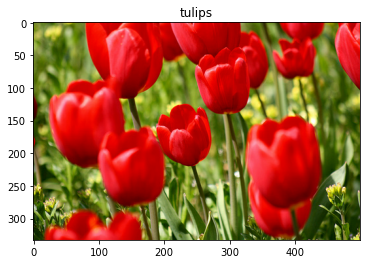

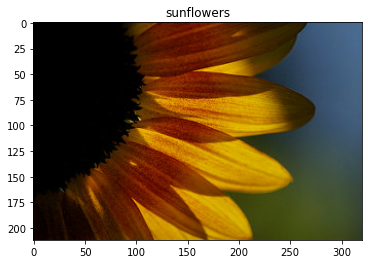

In [16]:
show_images(training_set)

<b>images are of different shape. so let's change to one shape</b>

In [17]:
SIZE=299

In [18]:
def format_example(image,label):
    print(label)
    image=tf.cast(image,tf.float32)
    image=image/127.5-1
    image = tf.image.resize(image,(SIZE,SIZE))
#     label=tf.keras.utils.to_categorical(label, 5)
    return image,label

In [19]:
training_set=training_set.map(format_example)
validation_set=validation_set.map(format_example)

Tensor("args_1:0", shape=(), dtype=int64)
Tensor("args_1:0", shape=(), dtype=int64)


<b>shuffle and batch training set and batch others</b>

In [20]:
batch_size=32
shuffle_buffer_size=2000

In [21]:
train_batch =  training_set.shuffle(shuffle_buffer_size).batch(batch_size)
validation_batch = validation_set.batch(batch_size)

<b>MobileNetV2 declare</b>

In [22]:
IMG_SHAPE = (SIZE, SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable=False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

<b>inspecting a single batch</b>

<p style="color:blue"><b>Here I'm showing one batch output and also defining the model</b><p>

In [50]:
for image_batch, label_batch in train_batch.take(1):
    pass
print (image_batch.shape)

(32, 299, 299, 3)


<b>let's see generated features</b>

In [51]:
feature_batch=base_model(image_batch)

In [52]:
feature_batch.shape

TensorShape([32, 10, 10, 1280])

<b>Now let's add some layers on top of MobileNetV2</b>

In [53]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg=global_average_layer(feature_batch)

In [54]:
feature_batch_avg.shape

TensorShape([32, 1280])

In [55]:
Dense_1=tf.keras.layers.Dense(100,activation='relu')
Dense_1_layer=Dense_1(feature_batch_avg)

In [56]:
Dense_1_layer.shape

TensorShape([32, 100])

In [57]:
Dense_2=tf.keras.layers.Dense(5,activation='softmax')
Dense_2_layer=Dense_2(Dense_1_layer)
# Dense_2_layer=Dense_2(feature_batch_avg)

In [58]:
Dense_2_layer.shape

TensorShape([32, 5])

<b>let's stack up these layers</b>

In [59]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    Dense_1,
    Dense_2
])

<b>Now let's compile model</b>

In [60]:
# learning_rate=0.0001
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

<b>let's compute initial accuracy using pretrained model</b>

In [61]:
model.evaluate(validation_batch)

35/35 [==============================] - 70s 2s/step - loss: 1.8506 - sparse_categorical_accuracy: 0.1708


[1.8506301641464233, 0.1707538664340973]

In [62]:
history = model.fit(train_batch,epochs=10,validation_data=validation_batch)

Epoch 1/10
81/81 [==============================] - 237s 3s/step - loss: 1.6261 - sparse_categorical_accuracy: 0.2546 - val_loss: 1.5572 - val_sparse_categorical_accuracy: 0.2825
Epoch 2/10
81/81 [==============================] - 236s 3s/step - loss: 1.5520 - sparse_categorical_accuracy: 0.3184 - val_loss: 1.4953 - val_sparse_categorical_accuracy: 0.3797
Epoch 3/10
81/81 [==============================] - 235s 3s/step - loss: 1.5121 - sparse_categorical_accuracy: 0.3523 - val_loss: 1.5037 - val_sparse_categorical_accuracy: 0.3270
Epoch 4/10
81/81 [==============================] - 234s 3s/step - loss: 1.4807 - sparse_categorical_accuracy: 0.3675 - val_loss: 1.4703 - val_sparse_categorical_accuracy: 0.3933
Epoch 5/10
81/81 [==============================] - 234s 3s/step - loss: 1.4462 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.4540 - val_sparse_categorical_accuracy: 0.4124
Epoch 6/10
81/81 [==============================] - 235s 3s/step - loss: 1.4537 - sparse_categorical_accu

<b>another architecture with only one dense layer [MobileNetV2 expects image of shape 160x160x3]</b>

In [2]:
(training_set, validation_set), dataset_info = tfdts.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
SIZE = 160

In [4]:
def format_example(image,label):
    print(label)
    image=tf.cast(image,tf.float32)
    image=image/127.5-1
    image = tf.image.resize(image,(SIZE,SIZE))
#     label=tf.keras.utils.to_categorical(label, 5)
    return image,label

In [5]:
training_set=training_set.map(format_example)
validation_set=validation_set.map(format_example)

Tensor("args_1:0", shape=(), dtype=int64)
Tensor("args_1:0", shape=(), dtype=int64)


In [6]:
IMG_SHAPE = (SIZE, SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable=False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
shuffle_buffer_size=2000
batch_size=32
train_batch =  training_set.shuffle(shuffle_buffer_size).batch(batch_size)
validation_batch = validation_set.batch(batch_size)

In [8]:
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_avg=global_average_layer(feature_batch)

In [9]:
Dense_2=tf.keras.layers.Dense(5,activation='softmax')
# Dense_2_layer=Dense_2(Dense_1_layer)
# Dense_2_layer=Dense_2(feature_batch_avg)

In [10]:

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
#     Dense_1,
    Dense_2
])

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

In [12]:
model.evaluate(validation_batch)

35/35 [==============================] - 20s 566ms/step - loss: 2.0955 - sparse_categorical_accuracy: 0.1689


[2.0954833030700684, 0.1689373254776001]

In [13]:
history = model.fit(train_batch,epochs=10,validation_data=validation_batch)

Epoch 1/10
81/81 [==============================] - 66s 819ms/step - loss: 0.8127 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.4516 - val_sparse_categorical_accuracy: 0.8465
Epoch 2/10
81/81 [==============================] - 67s 821ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.8762 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8765
Epoch 3/10
81/81 [==============================] - 66s 818ms/step - loss: 0.2773 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.3179 - val_sparse_categorical_accuracy: 0.8928
Epoch 4/10
81/81 [==============================] - 66s 821ms/step - loss: 0.2270 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3094 - val_sparse_categorical_accuracy: 0.8910
Epoch 5/10
81/81 [==============================] - 70s 859ms/step - loss: 0.1917 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8983
Epoch 6/10
81/81 [==============================] - 68s 839ms/step - loss: 0.1620 - sparse_cate

<p style="color:red"><b>Learned:</b></p>
<ul><li>Sent the shape that MobileNetV2 expects. Thus improved on validation set. You should verify the result on test set<\li><\ul>

<b>That's how data is loaded from tensorflow dataset</b>

In [14]:
(training_set, validation_set, test_set), dataset_info = tfdts.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

<h1>Deep dream network</h1>

In [1]:
import tensorflow as tf
import os
import numpy as np
import time
import tensorflow_datasets as tfdts
import matplotlib.pyplot as plt

<b>scale input to [-1,1]</b>

In [2]:
def preprocess(img):
    return img/127.5-1

<b>download image</b>

In [3]:
def download(url):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path)
    return image.img_to_array(img)

In [4]:
img=plt.imread('8944_1-PIA24546-1280.jpeg')

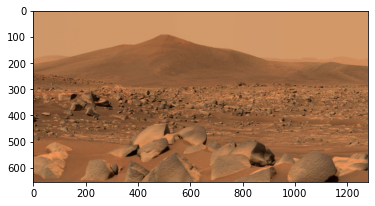

In [5]:
plt.imshow(img)

In [6]:
img=preprocess(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


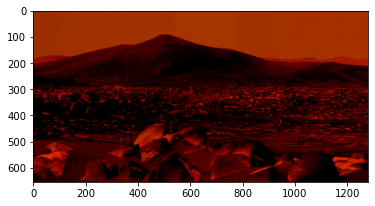

In [7]:
plt.imshow(img)

In [8]:
img.shape

(654, 1280, 3)

<b>Let's get some layers of InceptionV3</b>
<p style="color:red">Don't run these</p>

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [17]:
model = InceptionV3(input_shape=(654,1280,3),include_top=False, weights='imagenet')

In [18]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 654, 1280, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 326, 639, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 326, 639, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 326, 639, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
for layer in model.layers:
    layer.trainable=False

In [21]:
img=np.expand_dims(img,axis=0)

In [22]:
img.shape

(1, 654, 1280, 3)

In [23]:
model(img).shape

TensorShape([1, 19, 38, 2048])

In [25]:
tf.keras.layers.GlobalAveragePooling2D()(model(img)).shape

TensorShape([1, 2048])

<b>Let's do something actually useful</b>
<p>Getting some layers by name</p>

<b>For DeepDream, the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'.</b>

<b>Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures).</b>

<b>deeper layer needs much more time to train</b>

In [37]:
names=['mixed2','mixed4']

In [38]:
base_model = tf.keras.applications.InceptionV3(input_shape=img.shape,include_top=False, weights='imagenet')

In [39]:
layers=[base_model.get_layer(name).output for name in names]

In [40]:
layers

[<tf.Tensor 'mixed2/concat_1:0' shape=(None, 79, 157, 288) dtype=float32>,
 <tf.Tensor 'mixed4/concat_1:0' shape=(None, 39, 78, 768) dtype=float32>]

In [41]:
feature_extractor = tf.keras.Model(inputs=base_model.input,outputs=layers)
# dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)